# Adaptive Data Debiasing through Bounded Exploraiton and Fairness

This code is under the Beta 1 group no fairness setting

Define true, initial, and other hyper-parameters 

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from scipy.stats import beta
import matplotlib.pyplot as plt

# Defining True Parameters for group 1 and 0
a1_true_group1 = 5           #f1_group_1 (5, 3)
a0_true_group1 = 3           #f0_group_1 (3, 5)
b1_true_group1 = 3
b0_true_group1 = 5

min_1_group1 = 4
max_1_group1 = 12
min_0_group1 = 2
max_0_group1 = 10

# Defining Initial Assumed Parameters
a1_init_group1 = 2           # (2,3)
a0_init_group1 = 5           # (5,5)
b1_init_group1 = b1_true_group1
b0_init_group1 = b0_true_group1

a1_group1=a1_init_group1
b1_group1=b1_init_group1
a0_group1=a0_init_group1
b0_group1=b0_init_group1

true_pop_prob_group1 = 0.5
exploration_porb_group1 = 1
generating_samples_group1 = 150000
existing_1_customers_group1 = 10000
existing_0_customers_group1 = 10000
batchsize = 4500
reference_quantile = 0.5


TP_group1 = 0
FP_group1 = 0
FN_group1 = 0
TN_group1 = 0
TP_oracle_group1 = 0 
FP_oracle_group1 = 0
FN_oracle_group1 = 0
TN_oracle_group1 = 0

Generate initial and incoming data and forget initial/true parameters defined above. From now on, the true and initial parameters are obtained by fitting data into distributions. 

In [2]:
# Generate initial data
data_1 = beta.rvs(a1_group1, b1_group1, loc=min_1_group1, scale=max_1_group1-min_1_group1, 
                  size=existing_1_customers_group1)
data_0 = beta.rvs(a0_group1, b0_group1, loc=min_0_group1, scale=max_0_group1-min_0_group1, 
                  size=existing_0_customers_group1)

# Generate incoming true data
label1 = beta.rvs(a1_true_group1, b1_true_group1, loc=min_1_group1, scale=max_1_group1-min_1_group1, 
                  size=int(generating_samples_group1*(1-true_pop_prob_group1)))
label0 = beta.rvs(a0_true_group1, b0_true_group1, loc=min_0_group1, scale=max_0_group1-min_0_group1, 
                  size=int(generating_samples_group1*true_pop_prob_group1))

# Obtain initial parameters via initial data
a1_group1, b1_group1, c,d = beta.fit(data_1, fb = b1_group1, floc = min_1_group1, fscale=max_1_group1-min_1_group1)
a0_group1, b0_group1, c,d = beta.fit(data_0, fb = b0_group1, floc = min_0_group1, fscale=max_0_group1-min_0_group1)

# Obtain true parameters via incoming true data
a1_true_group1, b1_group1, c,d = beta.fit(label1, fb = b1_group1, floc = min_1_group1, fscale=max_1_group1-min_1_group1)
a0_true_group1, b0_group1, c,d = beta.fit(label0, fb = b0_group1, floc = min_0_group1, fscale=max_0_group1-min_0_group1)
print ("Initial parameter a1_group1 is ", a1_group1)
print ("Initial parameter a0_group1 is ", a0_group1)
print ("True parameter a1_true_group1 is ", a1_true_group1)
print ("True parameter a0_true_group1 is ", a0_true_group1)

Initial parameter a1_group1 is  2.000425262773392
Initial parameter a0_group1 is  5.037016272097128
True parameter a1_true_group1 is  5.009984894486514
True parameter a0_true_group1 is  2.984907042865303


Find the initial classifier threshold and oracle classifier threshold from the initial data and incoming true data respectively. In addition, find out the corresponding LB and UB

In [3]:
# Find the classifier through Logistic Classifier
X_train = np.append(data_1, data_0).reshape(-1,1)
y_train = np.append(np.ones(len(data_1)),np.zeros(len(data_0))).reshape(-1,)
classifier_1 = LogisticRegression().fit(X_train,y_train)
# Obtain numerical value for classifier_group1 by solving
# 0 = beta_0 + beta_1 * classifier_group1 in logistic regression
classifier_group1 = float(-classifier_1.intercept_/classifier_1.coef_)
print ("Initial classifier is ", classifier_group1)

# Find the LB and UB (Using alpha = 60 for label 0 and median for label 1)
temp = 2*beta.cdf(beta.ppf(reference_quantile,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1),a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1) -\
            beta.cdf(classifier_group1,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1)
LB_group1 = max(min_0_group1, float(beta.ppf(temp,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1)))

temp = 2*beta.cdf(beta.ppf(0.5,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1),a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1) -\
            beta.cdf(LB_group1,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1)
UB_group1 = min(max_1_group1, float(beta.ppf(temp,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1)))

# Find oracle classifier and its value
X_train_oracle = np.append(label1, label0).reshape(-1,1)
y_train_oracle = np.append(np.ones(len(label1)),np.zeros(len(label0))).reshape(-1,)
classifier_oracle = LogisticRegression().fit(X_train_oracle, y_train_oracle)
classifier_oracle_value = float(-classifier_oracle.intercept_/classifier_oracle.coef_)
print ("Oracle classifier is ", classifier_oracle_value)

Initial classifier is  6.5702664358689615
Oracle classifier is  6.994932165497552


Build the info dataframe, which contains the information of ('True Label','Values','Decision','RP_1','RP_0', 'Classifier','Regret','Explore_Prob')

In [4]:
info_group1 = pd.DataFrame(columns = ['True Label','Values','Decision','RP_1_group1','RP_0_group1',
                                      'Classifier_group1','Explore_Prob_group1','Alpha_1_group1',
                                      'Alpha_0_group1','Regret','acceptwrong','rejectyes'])

# Assign feature values to the dataframe
info_group1['Values'] = np.append(label1, label0)
# Assign true labels to the dataframe
info_group1.loc[0:len(label1),'True Label'] = 1
info_group1.loc[len(label1):,'True Label'] = 0
# Shuffle the dataframe
info_group1 = shuffle(info_group1)
# Resign the index 
info_group1.reset_index(inplace=True, drop=True)

Perform the parameter update once the size of data falling into the updating range reaches the batchsize

In [5]:
i = 0
# Create loop for updating
while (i <= len(info_group1)-1):
    data_1_trun = []
    data_0_trun = []
    
    # find quantile of reference point including label 0 tail  
    portion_right0_group1 = (beta.sf(beta.ppf(reference_quantile,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1),
                                    a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1)
                     /beta.sf(LB_group1,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1))
    portion_left0_group1 = 1 - portion_right0_group1
    
    portion_right1_group1 = (beta.sf(beta.ppf(0.5,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1),
                                    a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1)
                     /beta.sf(LB_group1,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1))
    portion_left1_group1 = 1 - portion_right1_group1
    
    k = len(data_0_trun)
    #loop into each batch
    while ((k <= batchsize) & (i <= len(info_group1)-1)):

        # Make decisions
        if (info_group1.loc[i,'Values'] >= classifier_group1) & (info_group1.loc[i,'Values']<=UB_group1):
            info_group1.loc[i,'Decision'] = 1
        elif (info_group1.loc[i,'Values'] < classifier_group1) & (info_group1.loc[i,'Values']>=LB_group1) & (np.random.uniform(size=1)<=exploration_porb_group1):
            info_group1.loc[i,'Decision'] = 1
        elif (info_group1.loc[i,'Values'] >= classifier_group1) & (info_group1.loc[i,'Values']>UB_group1):
            info_group1.loc[i,'Decision'] = 1
        elif (info_group1.loc[i,'Values'] < classifier_group1) & (info_group1.loc[i,'Values']<LB_group1):
            info_group1.loc[i,'Decision'] = 3
        else:
            info_group1.loc[i,'Decision'] = 0  
    
        # Record confusion matrix
        if (info_group1.loc[i,'True Label']==1) & ((info_group1.loc[i,'Decision']==1) or (info_group1.loc[i,'Decision']==2)):
            TP_group1 += 1
        elif (info_group1.loc[i,'True Label']==1) & ((info_group1.loc[i,'Decision']==0) or (info_group1.loc[i,'Decision']==3)):
            FN_group1 += 1
        elif (info_group1.loc[i,'True Label']==0) & ((info_group1.loc[i,'Decision']==0) or (info_group1.loc[i,'Decision']==3)):
            TN_group1 += 1
        else:
            FP_group1 += 1
    
        # Record oracle matrix
        if (classifier_oracle.predict([[info_group1.loc[i,'Values']]]) == 1) & (info_group1.loc[i,'True Label']==1):
            TP_oracle_group1 += 1
        elif (classifier_oracle.predict([[info_group1.loc[i,'Values']]]) == 1) & (info_group1.loc[i,'True Label']==0):
            FP_oracle_group1 += 1
        elif (classifier_oracle.predict([[info_group1.loc[i,'Values']]]) == 0) & (info_group1.loc[i,'True Label']==1):
            FN_oracle_group1 += 1
        else:
            TN_oracle_group1 += 1
    
        
        # Record label 1 information for updating
        if (info_group1.loc[i,'True Label']==1) & (info_group1.loc[i,'Decision']==1):
            data_1 = np.append(data_1, info_group1.loc[i,'Values'])
            if (((info_group1.loc[i,'Values'] < classifier_group1) & (info_group1.loc[i,'Decision']==1)) 
               or ((info_group1.loc[i,'Values'] >= classifier_group1) & (info_group1.loc[i,'Decision']==1) & (np.random.uniform(size=1)<=exploration_porb_group1))):
                data_1_trun = np.append(data_1_trun, info_group1.loc[i,'Values'])
        else:
            data_1 = data_1 
            data_1_trun = data_1_trun
    
        
        # Record label 0 information for updating
        if (info_group1.loc[i,'True Label']==0) & (info_group1.loc[i,'Decision']==1):
            data_0 = np.append(data_0, info_group1.loc[i,'Values'])
            if (((info_group1.loc[i,'Values'] < classifier_group1) & (info_group1.loc[i,'Decision']==1)) 
                or ((info_group1.loc[i,'Values'] >= classifier_group1) & (np.random.uniform(size=1)<=exploration_porb_group1))):
                data_0_trun = np.append(data_0_trun, info_group1.loc[i,'Values'])
        else:
            data_0 = data_0 
            data_0_trun = data_0_trun
        
        k = len(data_0_trun)
        i = i + 1
        
    # Record new mean value/RP and classifier
    info_group1.loc[i-1,'RP_1_group1'] = np.quantile(data_1_trun, portion_left1_group1) 
    info_group1.loc[i-1,'RP_0_group1'] =  np.quantile(data_0_trun, portion_left0_group1) 
    info_group1.loc[i-1,'Classifier_group1'] = classifier_group1
    info_group1.loc[i-1,'Regret'] = (FP_group1 + FN_group1)-(FP_oracle_group1 + FN_oracle_group1)
    info_group1.loc[i-1,'Explore_Prob_group1'] = exploration_porb_group1
    
    info_group1.loc[i-1,'acceptwrong'] = FP_group1
    info_group1.loc[i-1,'rejectyes'] = FN_group1
    
    x = np.arange(0.01,10,0.01)
    # Reassign new values to parameters
    def f(alpha):
        return abs(beta.cdf(info_group1.loc[i-1,'RP_1_group1'], alpha, b1_group1, loc=min_1_group1, scale=max_1_group1-min_1_group1) - 0.5)
    info_group1.loc[i-1,'Alpha_1_group1'] = np.argmin(f(x))*0.01
    
    def f(alpha):
        return abs(beta.cdf(info_group1.loc[i-1,'RP_0_group1'], alpha, b0_group1, loc=min_0_group1, scale=max_0_group1-min_0_group1) - reference_quantile)
    info_group1.loc[i-1,'Alpha_0_group1'] = np.argmin(f(x))*0.01
    
    a1_group1 = info_group1.loc[i-1,'Alpha_1_group1']
    a0_group1 = info_group1.loc[i-1,'Alpha_0_group1']
    
    # Update classifier, UB and LB
    X_train = np.append(data_1, data_0).reshape(-1,1)
    y_train = np.append(np.ones(len(data_1)),np.zeros(len(data_0))).reshape(-1,)
    classifier_1 = LogisticRegression().fit(X_train, y_train)
    classifier_group1 = float(-classifier_1.intercept_/classifier_1.coef_)
    
    temp = 2*beta.cdf(beta.ppf(reference_quantile,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1),a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1) -\
            beta.cdf(classifier_group1,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1)
    LB_group1 = max(min_0_group1, float(beta.ppf(temp,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1)))

    temp = 2*beta.cdf(beta.ppf(0.5,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1),a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1) -\
            beta.cdf(LB_group1,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1)
    UB_group1 = min(max_1_group1, float(beta.ppf(temp,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1)))
    
    # Update exploration probability
    theoretical_value_group1 = beta.sf(classifier_group1,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1) \
                                /beta.sf(LB_group1,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1)
    experiment_value_group1 = len(data_0_trun[data_0_trun>=classifier_group1])/len(data_0_trun[data_0_trun>=LB_group1])
    diff_group1 = abs(theoretical_value_group1 - experiment_value_group1)
    exploration_porb_group1 = 1 - 0.1*(i//(generating_samples_group1/10)) 

In [6]:
# Add initial information to thhe DataFrame
initial_information = []
initial_information.insert(0, {'True Label':'NA','Values':'NA','Decision':'NA','RP_1_group1':'NA','RP_0_group1':'NA',
                                      'Classifier_group1':'NA','Explore_Prob_group1':1,'Alpha_1_group1':a1_init_group1,
                                      'Alpha_0_group1':a0_init_group1,'Regret':0,'acceptwrong':0, 'rejectyes':0})
info_group1 = pd.concat([pd.DataFrame(initial_information), info_group1], ignore_index=True)

Performance visualization

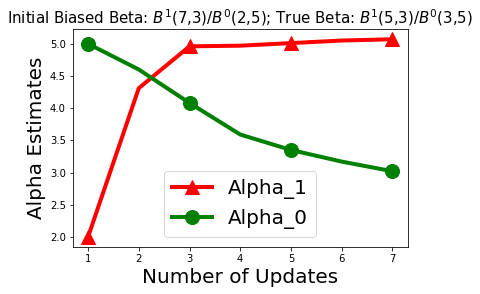

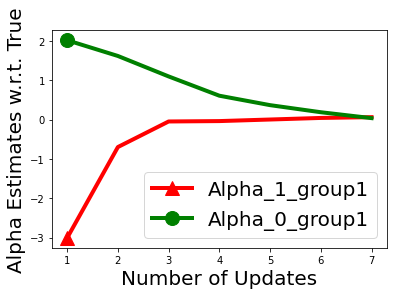

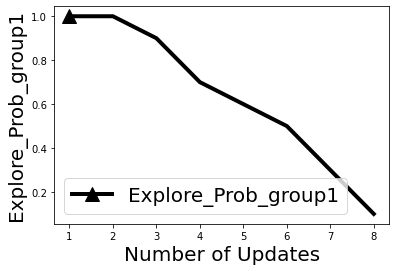

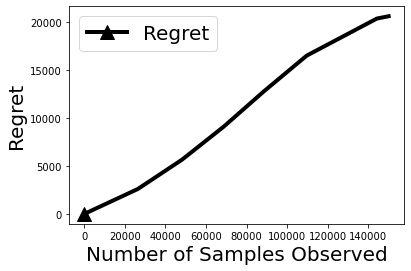

In [7]:
plt.plot(np.arange(1,len(info_group1['Alpha_1_group1'].dropna()),1),info_group1['Alpha_1_group1'].dropna()[:len(info_group1['Alpha_1_group1'].dropna())-1],
         lw=4,color='red',marker='^',ms=14, markevery=2,markerfacecolor='red')
plt.plot(np.arange(1,len(info_group1['Alpha_0_group1'].dropna()),1),info_group1['Alpha_0_group1'].dropna()[:len(info_group1['Alpha_0_group1'].dropna())-1],
         lw=4,color='green', marker='o',ms=14, markevery=2,markerfacecolor='green')
plt.legend(['Alpha_1','Alpha_0'],fontsize=20)
plt.title("Initial Biased Beta: $B^1$(7,3)/$B^0$(2,5); True Beta: $B^1$(5,3)/$B^0$(3,5)",fontsize=15)
plt.xlabel('Number of Updates', fontsize=20)
plt.ylabel('Alpha Estimates', fontsize=20)
plt.show()


plt.plot(np.arange(1,len(info_group1['RP_1_group1'].dropna()),1),info_group1['Alpha_1_group1'].dropna()[:len(info_group1['Alpha_1_group1'].dropna())-1]-a1_true_group1,
         lw=4,color='red',marker='^',ms=14, markevery=40,markerfacecolor='red')
plt.plot(np.arange(1,len(info_group1['RP_0_group1'].dropna()),1),info_group1['Alpha_0_group1'].dropna()[:len(info_group1['Alpha_0_group1'].dropna())-1]-a0_true_group1,
         lw=4,color='green', marker='o',ms=14, markevery=40,markerfacecolor='green')
plt.legend(['Alpha_1_group1','Alpha_0_group1'],fontsize=20)
plt.xlabel('Number of Updates', fontsize=20)
plt.ylabel('Alpha Estimates w.r.t. True', fontsize=20)
plt.show()

plt.plot(np.arange(1,len(info_group1['Explore_Prob_group1'].dropna())+1,1),info_group1['Explore_Prob_group1'].dropna(),
         lw=4,color='black',marker='^',ms=14, markevery=40,markerfacecolor='black')
plt.legend(['Explore_Prob_group1'],fontsize=20)
plt.xlabel('Number of Updates', fontsize=20)
plt.ylabel('Explore_Prob_group1', fontsize=20)
plt.show()

plt.plot(info_group1['Regret'].dropna().index,info_group1['Regret'].dropna(),
         lw=4,color='black',marker='^',ms=14, markevery=40,markerfacecolor='black')
plt.legend(['Regret'],fontsize=20)
plt.xlabel('Number of Samples Observed', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.show()

In [88]:
%store
# %store -r

Stored variables and their in-db values:


In [131]:
info_group1.to_csv('beta_1_group_nofair_FNFP60.csv')

Text(0, 0.5, 'Alpha Estimates')

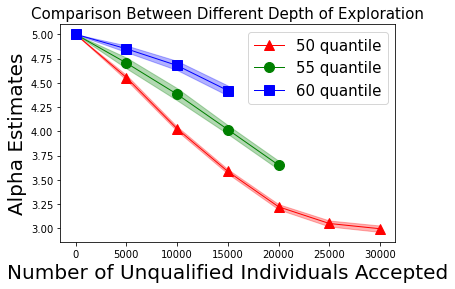

In [384]:
x1 = np.linspace(0, 30000, 7)
data_1 = np.array([5,5,5,5,5])
mean_1 = np.mean(data_1)
sd_1 = np.std(data_1, ddof=1) 

data_2 = np.array([4.53, 4.59, 4.57, 4.55, 4.53])
mean_2 = np.mean(data_2)
sd_2 = np.std(data_2, ddof=1) 

data_3 = np.array([4, 4.05, 4.02, 4.01, 4.05])
mean_3 = np.mean(data_3)
sd_3 = np.std(data_3, ddof=1) 

data_4 = np.array([3.61, 3.6, 3.58, 3.59, 3.55])
mean_4 = np.mean(data_4)
sd_4 = np.std(data_4, ddof=1) 

data_5 = np.array([3.26, 3.24, 3.2, 3.2, 3.21])
mean_5 = np.mean(data_5)
sd_5 = np.std(data_5, ddof=1) 

data_6 = np.array([3.1, 3.05, 3.02, 3.03, 3.05])
mean_6 = np.mean(data_6)
sd_6 = np.std(data_6, ddof=1) 

data_7 = np.array([3, 3.02, 2.94, 3, 3.02])
mean_7 = np.mean(data_7)
sd_7 = np.std(data_7, ddof=1) 

x2 = np.linspace(0, 20000, 5)
bdata_1 = np.array([5,5,5,5,5])
bmean_1 = np.mean(bdata_1)
bsd_1 = np.std(bdata_1, ddof=1) 

bdata_2 = np.array([4.76, 4.65, 4.75, 4.64, 4.72])
bmean_2 = np.mean(bdata_2)
bsd_2 = np.std(bdata_2, ddof=1) 

bdata_3 = np.array([4.46, 4.3, 4.41, 4.34, 4.4])
bmean_3 = np.mean(bdata_3)
bsd_3 = np.std(bdata_3, ddof=1) 

bdata_4 = np.array([4.07, 3.97, 4.04, 3.97, 4.04])
bmean_4 = np.mean(bdata_4)
bsd_4 = np.std(bdata_4, ddof=1) 

bdata_5 = np.array([3.68, 3.59, 3.69, 3.62, 3.68])
bmean_5 = np.mean(bdata_5)
bsd_5 = np.std(bdata_5, ddof=1) 


x3 = np.linspace(0, 15000, 4)

cdata_1 = np.array([5,5,5,5,5])
cmean_1 = np.mean(cdata_1)
csd_1 = np.std(cdata_1, ddof=1) 

cdata_2 = np.array([4.82, 4.83, 4.83, 4.9, 4.87])
cmean_2 = np.mean(cdata_2)
csd_2 = np.std(cdata_2, ddof=1) 

cdata_3 = np.array([4.62, 4.68, 4.66, 4.75, 4.68])
cmean_3 = np.mean(cdata_3)
csd_3 = np.std(cdata_3, ddof=1) 

cdata_4 = np.array([4.34, 4.47, 4.4, 4.45, 4.44])
cmean_4 = np.mean(cdata_4)
csd_4 = np.std(cdata_4, ddof=1) 


line = np.array([mean_1, mean_2, mean_3, mean_4, mean_5, mean_6, mean_7])
line_sd = np.array([sd_1, sd_2, sd_3, sd_4, sd_5, sd_6, sd_7])
plt.plot(x1, line, lw=1,color='red',marker='^',ms=10, markevery=1,markerfacecolor='red')
plt.fill_between(x1, line+line_sd, line-line_sd, alpha=0.3, color = "red")

line2 = np.array([bmean_1, bmean_2, bmean_3, bmean_4, bmean_5])
line2_sd = np.array([bsd_1, bsd_2, bsd_3, bsd_4, bsd_5])
plt.plot(x2, line2, lw=1,color='green', marker='o',ms=10, markevery=1,markerfacecolor='green')

plt.fill_between(x2, line2 - line2_sd, line2 + line2_sd, alpha=0.3, color = "green")

line3 = np.array([cmean_1, cmean_2, cmean_3, cmean_4])
line3_sd = np.array([csd_1, csd_2, csd_3, csd_4])
plt.plot(x3, line3, lw=1,color='blue', marker='s',ms=10, markevery=1,markerfacecolor='blue')

plt.fill_between(x3, line3 - line3_sd, line3 + line3_sd, alpha=0.3, color = "blue")


plt.legend(['50 quantile','55 quantile', '60 quantile'],fontsize=15)
plt.title("Comparison Between Different Depth of Exploration",fontsize=15)
plt.xlabel('Number of Unqualified Individuals Accepted', fontsize=20)
plt.ylabel('Alpha Estimates', fontsize=20)


Text(0, 0.5, 'Alpha Estimates')

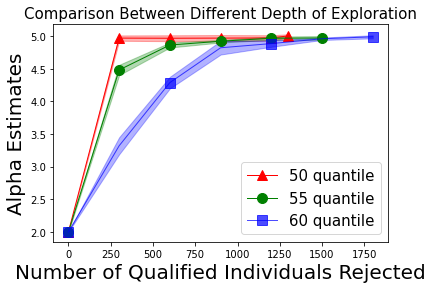

In [412]:
x1 = np.linspace(0, 1200, 5)
x1 = np.append(x1, 1300)
data_1 = np.array([2,2,2,2,2])
mean_1 = np.mean(data_1)
sd_1 = np.std(data_1, ddof=1) 

data_2 = np.array([4.97, 4.9, 4.98, 5, 5])
mean_2 = np.mean(data_2)
sd_2 = np.std(data_2, ddof=1) 

data_3 = np.array([5.01, 4.9, 4.96, 4.96, 5.01])
mean_3 = np.mean(data_3)
sd_3 = np.std(data_3, ddof=1) 

data_4 = np.array([5, 4.9, 4.98, 4.95, 5.02])
mean_4 = np.mean(data_4)
sd_4 = np.std(data_4, ddof=1) 

data_5 = np.array([5, 4.9, 4.97, 4.99, 5])
mean_5 = np.mean(data_5)
sd_5 = np.std(data_5, ddof=1) 

data_6 = np.array([4.99, 5.02, 4.99, 5.04, 4.98])
mean_6 = np.mean(data_6)
sd_6 = np.std(data_6, ddof=1) 


x2 = np.linspace(0, 1500, 6)
bdata_1 = np.array([2,2,2,2,2])
bmean_1 = np.mean(bdata_1)
bsd_1 = np.std(bdata_1, ddof=1) 

bdata_2 = np.array([4.45, 4.56, 4.51, 4.53, 4.36])
bmean_2 = np.mean(bdata_2)
bsd_2 = np.std(bdata_2, ddof=1) 

bdata_3 = np.array([4.85, 4.83, 4.86, 4.93, 4.85])
bmean_3 = np.mean(bdata_3)
bsd_3 = np.std(bdata_3, ddof=1) 

bdata_4 = np.array([4.93, 4.91, 4.92, 4.95, 4.9])
bmean_4 = np.mean(bdata_4)
bsd_4 = np.std(bdata_4, ddof=1) 

bdata_5 = np.array([4.97, 4.95, 4.96, 5.01, 4.95])
bmean_5 = np.mean(bdata_5)
bsd_5 = np.std(bdata_5, ddof=1) 

bdata_6 = np.array([4.99, 4.92, 4.99, 4.98, 4.98])
bmean_6 = np.mean(bdata_6)
bsd_6 = np.std(bdata_6, ddof=1) 

x3 = np.linspace(0, 1800, 7)

cdata_1 = np.array([2,2,2,2,2])
cmean_1 = np.mean(cdata_1)
csd_1 = np.std(cdata_1, ddof=1) 

cdata_2 = np.array([3.2, 3.5, 3.4, 3.2, 3.3])
cmean_2 = np.mean(cdata_2)
csd_2 = np.std(cdata_2, ddof=1) 

cdata_3 = np.array([4.3, 4.4, 4.3, 4.15, 4.29])
cmean_3 = np.mean(cdata_3)
csd_3 = np.std(cdata_3, ddof=1) 

cdata_4 = np.array([4.88, 4.87, 4.91, 4.65, 4.8])
cmean_4 = np.mean(cdata_4)
csd_4 = np.std(cdata_4, ddof=1) 

cdata_5 = np.array([4.9, 4.91, 4.92, 4.8, 4.9])
cmean_5 = np.mean(cdata_5)
csd_5 = np.std(cdata_5, ddof=1) 

cdata_6 = np.array([4.96, 4.96, 4.95, 4.94, 4.99])
cmean_6 = np.mean(cdata_6)
csd_6 = np.std(cdata_6, ddof=1) 

cdata_7 = np.array([5.01, 4.97, 4.96, 5.01, 5])
cmean_7 = np.mean(cdata_7)
csd_7 = np.std(cdata_7, ddof=1) 


line = np.array([mean_1, mean_2, mean_3, mean_4, mean_5, mean_6])
line_sd = np.array([sd_1, sd_2, sd_3, sd_4, sd_5, sd_6])
plt.plot(x1, line, lw=1,color='red',marker='^',ms=10, markevery=1,markerfacecolor='red')
plt.fill_between(x1, line+line_sd, line-line_sd, alpha=0.3, color = "red")

line2 = np.array([bmean_1, bmean_2, bmean_3, bmean_4, bmean_5, bmean_6])
line2_sd = np.array([bsd_1, bsd_2, bsd_3, bsd_4, bsd_5, bsd_6])
plt.plot(x2, line2, lw=1,color='green', marker='o',ms=10, markevery=1,markerfacecolor='green')

plt.fill_between(x2, line2 - line2_sd, line2 + line2_sd, alpha=0.3, color = "green")

line3 = np.array([cmean_1, cmean_2, cmean_3, cmean_4, cmean_5, cmean_6, cmean_7])
line3_sd = np.array([csd_1, csd_2, csd_3, csd_4, csd_5, csd_6, csd_7])
plt.plot(x3, line3, lw=1,color='blue', marker='s',ms=10, markevery=2,markerfacecolor='blue',alpha = 0.7)

plt.fill_between(x3, line3 - line3_sd, line3 + line3_sd, alpha=0.3, color = "blue")


plt.legend(['50 quantile','55 quantile', '60 quantile'],fontsize=15)
plt.title("Comparison Between Different Depth of Exploration",fontsize=15)
plt.xlabel('Number of Qualified Individuals Rejected', fontsize=20)
plt.ylabel('Alpha Estimates', fontsize=20)